## Air Quality Dashboard
This notebook shows how to use IPython Widgets to display the air quality using Grove Sensors.

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox
import random
import threading
from IPython.display import display
import time
import math
from redpitaya.overlay.mercury import mercury as FPGA

%matplotlib notebook
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
from datetime import datetime, date
import pandas as pd


overlay = FPGA()
ANALOG_TEMP = FPGA.analog_in(0) # define which pin will be used for temperature sensor

Requested overlay is already loaded.


In [2]:
def res_to_temp(Rntc):
    B = 4275; # B value of the thermistor
    return (1.0/(math.log10(Rntc/100000.0)/B+1/298.15)-273.15) #convert to temperature via datasheet 
temp = [ res_to_temp(R) for R in range(10000,300000,100)]

def temp():
    Va0=ANALOG_TEMP.read() # read voltage of sensor
    R0 = 100000;       # R0 = 100k
    Rntc = 3.3/(Va0)-1.0 
    Rntc = 100000.0*Rntc # thermistor resistance
    return (res_to_temp(Rntc),Va0);
latest_temp=temp()

In [3]:
voc_air_pin = FPGA.analog_in(1) # define which pin will be used for VOC sensor
voc_air = voc_air_pin.read()
voc_air = 0.053 #Refrence value with no voc

In [4]:
ANALOG_Alcohol_pin = FPGA.analog_in(2) # define which pin will be used for alcohol sensor
Alcohol_air = ANALOG_Alcohol_pin.read()

In [5]:
Alcohol_volt = ANALOG_Alcohol_pin.read()
Alcohol_gas = Alcohol_volt/(5.0-Alcohol_volt)
#Scale the result to be between 2.0 and 30.0 to keep on a similar scale to temperature
Alcohol_ratio = (1/(Alcohol_gas/1.85))*2
keep_going = True
def work():
    while keep_going == True:
        Alcohol_volt = ANALOG_Alcohol_pin.read()
        Alcohol_gas = Alcohol_volt/(5.0-Alcohol_volt)
        #Scale the result to be between 2.0 and 30.0 to keep on a similar scale to temperature
        Alcohol_ratio = (1/(Alcohol_gas/1.85))*2
        print(Alcohol_gas, Alcohol_volt, Alcohol_ratio)
        clear_output(wait=True)
        time.sleep(1)

thread = threading.Thread(target=work)
thread.start()

2.545838007270351 3.589896100795341 1.453352487249235


In [6]:
voc_volt = voc_air_pin.read()
voc_gas = voc_volt/(5.0)
#Scale the result to be between 2.0 and 30.0 to keep on a similar scale to temperature
voc_ratio = (voc_gas/voc_air)*3
keep_going = True
def work():
    while keep_going == True:
        voc_volt = voc_air_pin.read()
        voc_gas = voc_volt/(5.0)
        #Scale the result to be between 2.0 and 30.0 to keep on a similar scale to temperature
        voc_ratio = (voc_gas/voc_air)*3
#        print(Alcohol_gas, voc_volt, Alcohol_ratio)
        print(voc_volt,voc_air,voc_ratio)
        clear_output(wait=True)
        time.sleep(1)

thread = threading.Thread(target=work)
thread.start()

0.23624495083917837 0.053 2.674471141575604


In [7]:
keep_going = False

In [8]:
voc_bar = widgets.widgets.FloatProgress(
    value=voc_ratio,
    min=0,
    max=1.0,
    description='VOC Air:',
    bar_style='info',
    style={'bar_color': '#fcdb03'},
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
voc_label = widgets.FloatText(
    value=voc_bar.value,
#    description='Any:',
    disabled=True
)

temp_bar = widgets.widgets.FloatProgress(
    value=latest_temp[0],
    min=0,
    max=36.0,
    description='Temperature:',
    bar_style='info',
    style={'bar_color': '#4ba329'},
    orientation='horizontal'
)

temp_slider = widgets.FloatSlider(
    value=latest_temp[0],
    min=0,
    max=36.0,
    step=0.1,
    description='Test:',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
alcohol_bar = widgets.widgets.FloatProgress(
    value=Alcohol_ratio,
    min=0,
    max=36.0,
    description='Alcohol:',
    bar_style='info',
    style={'bar_color': '#69fffc'},
    orientation='horizontal'
)

alcohol_label = widgets.FloatText(
    value=Alcohol_ratio,
#    description='Any:',
    disabled=True
)

update_air_quality = True


def work(voc_bar):
    while update_air_quality == True:
        time.sleep(0.2)
        voc_volt = voc_air_pin.read()
        voc_gas = voc_volt/(5.0)
        #Scale the result to be between 2.0 and 30.0 to keep on a similar scale to temperature
        voc_ratio = (voc_gas/voc_air)*3
        voc_bar.value = voc_ratio
        voc_label.value = voc_bar.value
        latest_temp=temp()[0]
        temp_bar.value = latest_temp
        temp_slider.value = latest_temp
        Alcohol_volt = ANALOG_Alcohol_pin.read()
        Alcohol_gas = Alcohol_volt/(5.0-Alcohol_volt)
        #Scale the result to be between 2.0 and 30.0 to keep on a similar scale to temperature
        Alcohol_ratio = (1/(Alcohol_gas/1.85))*2
        
        alcohol_bar.value = Alcohol_ratio
        alcohol_label.value = Alcohol_ratio

thread = threading.Thread(target=work, args=(voc_bar,))
#display(progress)
#display(progress_label)
#display(temp_bar)
#display(temp_slider)
thread.start()

first_box = HBox([voc_bar, voc_label])
second_box = HBox([temp_bar, temp_slider])
third_box = HBox([alcohol_bar, alcohol_label])
VBox([first_box, second_box, third_box])

In [9]:
threading.active_count()

6

In [10]:
update_air_quality = False

<IPython.core.display.Javascript object>


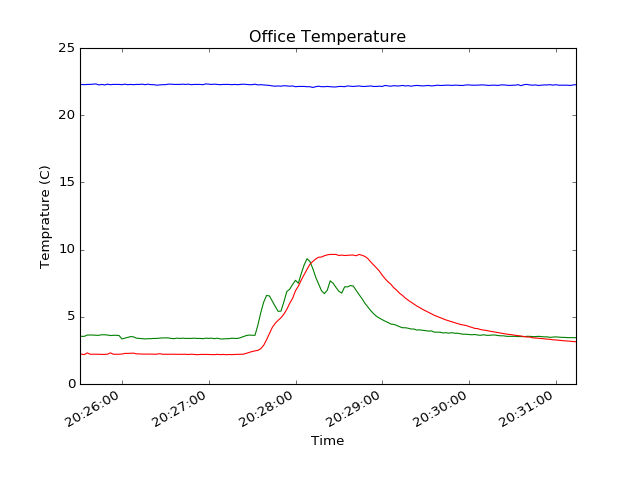

In [14]:
df = pd.DataFrame() #Create an empty data frame to append to later
def animate(i):
    global df
    clean_data_table = pd.DataFrame() #Create an empty data frame to append to later
    latest_temp=temp()[0]
    voc_volt = voc_air_pin.read()
    voc_gas = voc_volt/(5.0)
    #Scale the result to be between 2.0 and 30.0 to keep on a similar scale to temperature
    voc_ratio = (voc_gas/voc_air)*3
    Alcohol_volt = ANALOG_Alcohol_pin.read()
    Alcohol_gas = Alcohol_volt/(5.0-Alcohol_volt)
    #Scale the result to be between 2.0 and 30.0 to keep on a similar scale to temperature
    Alcohol_ratio = (1/(Alcohol_gas/1.85))*2
    clear_output(wait=True)
    clean_data_table['Temperature (oC)'] = [latest_temp]
    clean_data_table['VOC in Air'] = [voc_ratio]
    clean_data_table['Alcohol in Air'] = [Alcohol_ratio]
    clean_data_table['Date'] = [datetime.now()]
    df = df.append(clean_data_table)
    
    x = df['Date']
    y1 = df['Temperature (oC)']
    y2 = df['VOC in Air']
    y3 = df['Alcohol in Air']
    
    plt.cla()
    plt.plot(x,y1,label='Temperature (oC)')
    plt.plot(x,y2,label='VOC in Air')
    plt.plot(x,y3,label='Alcohol in Air')
    plt.xlabel('Time')
    plt.ylabel('Temprature (C)')
    plt.title("Office Temperature")
    plt.gcf().autofmt_xdate()
    plt.ticklabel_format(useOffset=False,axis='y')
#    plt.legend()
    plt.show()
    
ani = FuncAnimation(plt.gcf(), animate,interval=2000)
plt.show()

In [15]:
df

,Temperature (oC),VOC in Air,Alcohol in Air,Date
0,22.290170,3.546581,2.234421,2022-04-02 20:25:30.864644
0,22.271343,3.546581,2.189145,2022-04-02 20:25:33.881486
0,22.290170,3.643482,2.313678,2022-04-02 20:25:35.880824
0,22.290170,3.643482,2.214932,2022-04-02 20:25:37.880326
0,22.308993,3.643482,2.218171,2022-04-02 20:25:39.879867
0,22.327812,3.624102,2.218171,2022-04-02 20:25:41.880110
0,22.252512,3.624102,2.208464,2022-04-02 20:25:43.880835
0,22.290170,3.662863,2.205235,2022-04-02 20:25:45.880509
0,22.252512,3.662863,2.202010,2022-04-02 20:25:47.879914
0,22.308993,3.643482,2.218171,2022-04-02 20:25:49.879992


In [17]:
filename = str(date.today()) + " voc sensor data.csv"
df.to_csv(filename)